# Text Classification with Fine Tuning Bert

## **Cek resource & Install**

In [ ]:
!pip install -r requirements.txt

In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


## **Load Dataset**

In [5]:
import pandas as pd

# Load dataset
df_dev = pd.read_csv('data/dev.csv')
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')

df_train.shape

(21601, 3)

In [6]:
df_train.sample(5)

,Unnamed: 0,text_a,label
13276,13276,short little clip for da memes like and follow...,no
11145,11145,emg main twitter wajib jbjb mutual ya yahh gw ...,no
19109,19109,penyampaian menkes terkesan santai headline me...,no
5945,5945,teknologi berkomunikasi memaksimalkan physical...,yes
9638,9638,dennysiregar7 kpai official ya gini sih susah ...,yes


## **Label Encoder**

In [7]:
df_train['worth'] = df_train['label'].apply(lambda x : 1 if x=='yes' else 0)
df_train.sample(5)

,Unnamed: 0,text_a,label,worth
17270,17270,rekrutmen cpns pppk ditiadakan,yes,1
14599,14599,silaturahmi fitri physical distancing https t ...,no,0
7992,7992,putraerlangga trirismaharini lho ssuai kpasita...,no,0
20323,20323,ghost konslet kasih tau menhub beliau kena corona,yes,1
11631,11631,asknonym iya bener virus disekitar cuman karna...,no,0


In [8]:
df_test['worth'] = df_test['label'].apply(lambda x : 1 if x=='yes' else 0)
df_test.sample(5)

,text_a,label,worth
220,hoaks pasien korona di indonesia,yes,1
2363,kemaren kerja deket tv client denger menkes ng...,no,0
196,kapansi covid 19 berhenti menyebar menghilang ...,no,0
1449,gadai cepat wa 0812 1800 9839 gadai rumah sert...,no,0
656,e100ss spt nya menkes sesuai panduan who https...,no,0


In [9]:
# val
df_dev['worth'] = df_dev['label'].apply(lambda x : 1 if x=='yes' else 0)
df_dev.sample(5)

,text_a,label,worth
2075,fadlizon matanajwa najwashihab fadjroel jokowi...,no,0
989,fikrii509 musim ujan bjir takut kena virus corona,no,0
11,grosir masker spirulina depok sms wa 082258435...,no,0
13,ramayanads ezash ramayana aja min depok graha ...,no,0
1696,anies baswedan bentuk tim khusus posko tanggap...,yes,1


## Cek Persebaran Data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

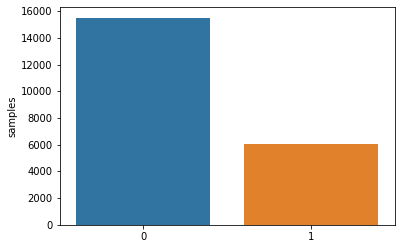

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

x=df_train.worth.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [11]:
sentences = df_train.text_a.values
labels = df_train.worth.values

sentences_test = df_test.text_a.values
labels_test = df_test.worth.values

sentences_val = df_dev.text_a.values
labels_val = df_dev.worth.values

## **Load BERT Tokenizer**

In [12]:
from transformers import BertTokenizer

print("Loading BERT Tokenizer")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT Tokenizer


In [13]:
df_train.sample(5)

,Unnamed: 0,text_a,label,worth
5641,5641,cakndu27 cakasana cari endorse pemprov,no,0
5747,5747,bansos polres cianjur program covid 19 polda j...,yes,1
6921,6921,fakta data umur 50 keatas rentan terjangkit vi...,yes,1
11081,11081,dapet kabar indonesia postif corona maafin kua...,yes,1
19472,19472,tu yg bilang indonesia kebal ame virus corona ...,no,0


### Tokenisasi dan Mapping Token Sentence ke Index di Tokenizer Vocabulary milik BERT Base Multilingua Uncased

In [14]:
print("Original: ", sentences[0])

print("Tokenized: ", tokenizer.tokenize(sentences[0]))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
Tokenized:  ['bete', '##we', 'bu', '##ka', 'twitter', 'cuma', '##n', 'ng', '##et', '##wee', '##t', 'lia', '##t', 'home', 'berita', 'corona', 'pani', '##k', 'kep', '##iki', '##ran', 'nda', '##mau', 'bu', '##ka', '##2', 'home', 'yg', 'aware', 'aja', 'i', 'll', 'stay', 'at', 'home', 'nda', 'rumah', 'kal', '##o', 'nda', 'penting', '##2', 'bang', '##et']
Token IDS:  [78811, 12351, 10920, 10358, 23588, 94097, 10115, 10822, 10337, 67954, 10123, 60241, 10123, 11402, 62637, 20241, 49034, 10167, 65911, 23802, 12056, 24305, 84144, 10920, 10358, 10835, 11402, 95759, 58910, 57950, 151, 17361, 22560, 10160, 11402, 24305, 20297, 54376, 10132, 24305, 33815, 10835, 12221, 10337]


### Memberikan token [CLS] di awal Token IDS dan token [SEP] di akhir untuk sentences yang di tokenized

In [15]:
# for train data
input_ids = []

for sent in sentences:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)

print("Original: ", sentences[0])
print("Token IDs: ", input_ids[0])



Token indices sequence length is longer than the specified maximum sequence length for this model (704 > 512). Running this sequence through the model will result in indexing errors


Original:  betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
Token IDs:  [101, 78811, 12351, 10920, 10358, 23588, 94097, 10115, 10822, 10337, 67954, 10123, 60241, 10123, 11402, 62637, 20241, 49034, 10167, 65911, 23802, 12056, 24305, 84144, 10920, 10358, 10835, 11402, 95759, 58910, 57950, 151, 17361, 22560, 10160, 11402, 24305, 20297, 54376, 10132, 24305, 33815, 10835, 12221, 10337, 102]


In [16]:
# for test data
input_ids_test = []

for sent in sentences_test:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids_test.append(encoded_sent)

print("Original: ", sentences_test[0])
print("Token IDs: ", input_ids_test[0])

Original:  jek dajal ga depok bang
Token IDs:  [101, 10149, 10167, 10141, 24842, 11747, 10102, 41938, 12221, 102]


In [17]:
# for val
input_ids_val = []

for sent in sentences_val:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids_val.append(encoded_sent)

print("Original: ", sentences_val[0])
print("Token IDs: ", input_ids_val[0])

Original:  jek dajal ga depok bang
Token IDs:  [101, 10149, 10167, 10141, 24842, 11747, 10102, 41938, 12221, 102]


In [18]:
# train data
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  2639


In [19]:
# test data
print("Max sentence length: ", max([len(sen) for sen in input_ids_test]))

Max sentence length:  640


In [20]:
# dev/val
print("Max sentence length: ", max([len(sen) for sen in input_ids_val]))

Max sentence length:  640


### Memberikan Padding

In [21]:
# train data
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [22]:
# test data
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [23]:
# val
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")


Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


### Attention Mask

In [24]:
attention_mask_train = []

for sent in input_ids:
  att_mask_train = [int(token_id > 0) for token_id in sent]

  attention_mask_train.append(att_mask_train)



In [25]:
attention_mask_test = []

for sent in input_ids_test:
  att_mask_test = [int(token_id > 0) for token_id in sent]

  attention_mask_test.append(att_mask_test)

In [26]:
attention_mask_val = []

for sent in input_ids_test:
  att_mask_val = [int(token_id > 0) for token_id in sent]

  attention_mask_val.append(att_mask_val)

## **Persiapkan data**

In [27]:
from sklearn.model_selection import train_test_split



# train & test
train_input = input_ids.copy()
train_labels = labels.copy()
test_input = input_ids_test.copy()
test_labels = labels_test.copy()




# mask train & test
train_mask = attention_mask_train.copy()
test_mask =attention_mask_test.copy()



# val
validation_input = input_ids_val.copy()
validation_labels = labels_val.copy()



# mask val
validation_mask = attention_mask_val.copy()

# train_input[0]
input_ids.shape


(21601, 64)

In [28]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (21601, 64)
Label:  (21601,)
Mask:  (21601, 64)

== Validation ==
Input:  (2800, 64)
Label:  (2800,)
Mask:  (2800, 64)

== Test ==
Input:  (2800, 64)
Label:  (2800,)
Mask:  (2800, 64)


In [29]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## **Persiapkan model pre-trained BERT**

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [32]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (105879, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.

### Optimizer

In [33]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [34]:
from transformers import get_linear_schedule_with_warmup

epochs = 5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [35]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

## **Training BERT**

In [37]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

======= Epoch 1 / 5 =======
Training...
Batch    40 of 2,701.     Elapsed: 0:00:06
Batch    80 of 2,701.     Elapsed: 0:00:12
Batch   120 of 2,701.     Elapsed: 0:00:17
Batch   160 of 2,701.     Elapsed: 0:00:23
Batch   200 of 2,701.     Elapsed: 0:00:28
Batch   240 of 2,701.     Elapsed: 0:00:34
Batch   280 of 2,701.     Elapsed: 0:00:39
Batch   320 of 2,701.     Elapsed: 0:00:45
Batch   360 of 2,701.     Elapsed: 0:00:51
Batch   400 of 2,701.     Elapsed: 0:00:56
Batch   440 of 2,701.     Elapsed: 0:01:02
Batch   480 of 2,701.     Elapsed: 0:01:07
Batch   520 of 2,701.     Elapsed: 0:01:13
Batch   560 of 2,701.     Elapsed: 0:01:19
Batch   600 of 2,701.     Elapsed: 0:01:24
Batch   640 of 2,701.     Elapsed: 0:01:30
Batch   680 of 2,701.     Elapsed: 0:01:36
Batch   720 of 2,701.     Elapsed: 0:01:41
Batch   760 of 2,701.     Elapsed: 0:01:47
Batch   800 of 2,701.     Elapsed: 0:01:53
Batch   840 of 2,701.     Elapsed: 0:01:58
Batch   880 of 2,701.     Elapsed: 0:02:04
Batch   920 of

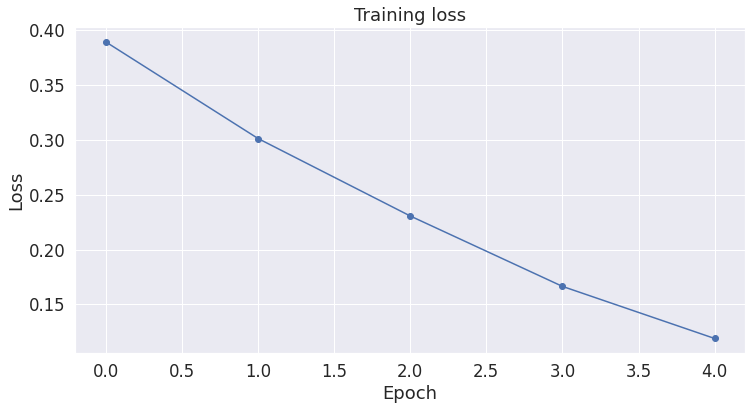

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## **Predict dan Evaluate**

In [40]:
print("Predicting labels for {:,} test sentences".format(len(test_input)))

model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

print(" DONE.")

Predicting labels for 2,800 test sentences
 DONE.


In [41]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.633


In [44]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)


ACC: 0.847


In [47]:
from sklearn.metrics import recall_score

recall = recall_score(flat_true_labels, flat_prediction)

print("RECALL: %.3f" %recall)


RECALL: 0.820
